In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, torchvision 
from PIL import Image

In [3]:
df_infos2 = pd.read_csv('../saved/infos2.csv')

In [5]:
# data_imgs = []
# for i in tqdm(range(len(df_infos2))):
#     with Image.open('../saved/channel_imgs/0/'+str(i)+'.png') as img:
#         data_imgs.append(img.copy())
import time
import pickle
st = time.time()
with open('../saved/channel_imgs0.pkg', 'rb') as f:
    data_imgs = pickle.load(f)
    
print((time.time()-st)/60, 'min')

1.9080170512199401 min


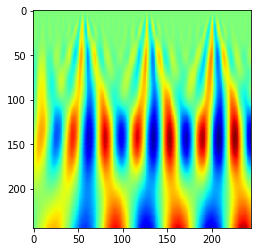

In [6]:
plt.imshow(data_imgs[0])

In [7]:
from global_vars import labels

In [8]:
from torch.utils.data import Dataset
from torchvision import transforms
import os
class MyImageDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, infos, data_imgs):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.infos = infos
        self.data_imgs = data_imgs
        self.transform =  transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])

    def __len__(self):
        return len(self.infos)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data_imgs[idx]
        info_labels = self.infos.iloc[idx][labels]
        sample =(self.transform(image), torch.Tensor(info_labels.astype(int)))

        

        return sample
    
image_datasets = MyImageDataset(df_infos2, data_imgs)

In [9]:
#X, y = image_datasets[0]

In [10]:
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=4,
                                             shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets)

```python
# The size of each initial batch.
BATCH_SIZE = 20
# The size of minibatch size which we want to pre-process.
MINIBATCH_SIZE = 1
# Initial number of images/data.
N = 100

batch = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
# Iterate over batches
for i, data in enumerate(batch):
    image, = data
    # Load the batch to GPU
    image = image.cuda()
    print(i, image.shape)
```

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:

def make_weights_for_balanced_classes(ys, weight_per_class):                                                                                          
    weight = [0] * len(ys)                                              
    for idx, y in enumerate(ys):    
        for i, val in enumerate(y):
            weight[idx] += weight_per_class[i]                           
    return weight  


In [13]:
from torchvision import datasets, models, transforms
from myeval import binary_acc
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
from sklearn.model_selection import GroupKFold
import time

st = time.time()
patience = 10
kf = GroupKFold(5)
batch_size=70

saved_dir = '../saved/modelCWTFullWeightedLoss/'
y = df_infos2[labels].astype(int)

for i, (train_idx, test_idx) in enumerate(kf.split(df_infos2, y, df_infos2['ptID'])):
    
    
    if i < 3:
        continue
        
#     df_y_train = df_infos2.iloc[train_idx][labels].to_numpy().astype(int)
#     weights = make_weights_for_balanced_classes(df_y_train, 1.0/np.sum(df_y_train,axis=0))

#     per_weights = torch.Tensor(weights).to(device)
#     sampler = torch.utils.data.sampler.WeightedRandomSampler(per_weights, len(train_idx))
    
    trainDataset = torch.utils.data.Subset(image_datasets, train_idx)
    testDataset = torch.utils.data.Subset(image_datasets, test_idx)
    
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle = True, pin_memory=True)#sampler = sampler)
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = False, pin_memory=True)

    model = models.resnet50(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    # change the last output to 9 classes
    model.fc = nn.Linear(num_ftrs, 9)
    model.to(device)
    
    
    # load saved model
#     if i == 0:
#         model_saved_path = saved_dir + 'CWTNetFull0_model.dict'
#         model.load_state_dict(torch.load(model_saved_path))
    
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
    # Decay LR by a factor of 0.1 every 100 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    class_weights = np.ones(9) * 2
    class_weights = torch.Tensor(class_weights).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    losses_train = []
    losses_test = []

    avg_losses_train = []
    avg_losses_test = []


    early_stopping = EarlyStopping(patience, verbose=False, 
                                  saved_dir=saved_dir, 
                                   save_name='modelCWTFull'+str(i))
    epoch = 0
    auroc = 0
    auprc = 0
    accuracy = 0
    fmeasure = 0
    fbeta = 0
    gbeta = 0
    for epoch in range(0, 100):
        
        model.train()
        output_trains = []
        y_trains = []
        for X_train, y_train in trainLoader:
            optimizer.zero_grad()
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            output_train = model(X_train)
            
            loss_train = criterion(output_train, y_train)
            losses_train.append(loss_train.item())
            loss_train.backward()
            optimizer.step()
            
            
            output_trains.append(output_train.cpu())
            y_trains.append(y_train.cpu())

        scheduler.step()
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
        
        output_tests = []
        y_tests = []
        with torch.no_grad():
            model.eval()
            
            for X_test, y_test in testLoader:  
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                output_test = model(X_test)
                
                loss_test = criterion(output_test, y_test)
                losses_test.append(loss_test.item())
                
                output_tests.append(output_test.cpu())
                y_tests.append(y_test.cpu())
                
            avg_loss_test = np.average(losses_test)
            avg_losses_test.append(avg_loss_test)

       
        
        output_trains = torch.cat(output_trains, axis=0)
        y_trains = torch.cat(y_trains, axis=0)
        acc, fmeasure, fbeta, gbeta, auroc, auprc = binary_acc(output_trains, y_trains)

        output_tests = torch.cat(output_tests, axis=0)
        y_tests = torch.cat(y_tests, axis=0)
        acc2, fmeasure2, fbeta2, gbeta2, auroc2, auprc2 = binary_acc(output_tests, y_tests)


        output_str = 'S{}/{} {:.2f} min|\nTrain Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, auroc: {:.3f}, auprc: {:.3f} |\nValid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, auroc: {:.3f}, auprc: {:.3f}\n '.format(
            i, epoch, (time.time()-st)/60,
            avg_loss_train, acc, fmeasure, fbeta, gbeta, auroc, auprc, 
            avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, auroc2, auprc2)
        print(output_str)
        
        with open(saved_dir+'loss{}.txt'.format(i), 'a') as f:
            print(output_str, file=f)
            
        early_stopping(avg_loss_test, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2)
    print(output_string)     
    with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
        f.write(output_string)

    avg_losses_train = np.array(avg_losses_train)
    avg_losses_test = np.array(avg_losses_test)
    
    np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
    np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)
    

S3/0 24.72 min|
Train Loss: 0.460112, Acc: 0.889, F: 0.175, Fbeta: 0.209, gbeta: 0.086, auroc: 0.761, auprc: 0.328 |
Valid Loss: 0.393366, Acc: 0.903, F: 0.360, Fbeta: 0.393, gbeta: 0.196, auroc: 0.832, auprc: 0.509
 
S3/1 50.12 min|
Train Loss: 0.398463, Acc: 0.916, F: 0.466, Fbeta: 0.490, gbeta: 0.279, auroc: 0.878, auprc: 0.581 |
Valid Loss: 0.361926, Acc: 0.918, F: 0.515, Fbeta: 0.520, gbeta: 0.322, auroc: 0.870, auprc: 0.586
 
S3/2 76.10 min|
Train Loss: 0.360807, Acc: 0.926, F: 0.557, Fbeta: 0.571, gbeta: 0.361, auroc: 0.910, auprc: 0.654 |
Valid Loss: 0.345599, Acc: 0.919, F: 0.554, Fbeta: 0.563, gbeta: 0.349, auroc: 0.883, auprc: 0.615
 
S3/3 102.02 min|
Train Loss: 0.333688, Acc: 0.934, F: 0.623, Fbeta: 0.638, gbeta: 0.420, auroc: 0.930, auprc: 0.711 |
Valid Loss: 0.335521, Acc: 0.921, F: 0.572, Fbeta: 0.584, gbeta: 0.365, auroc: 0.893, auprc: 0.636
 
S3/4 128.33 min|
Train Loss: 0.311589, Acc: 0.942, F: 0.679, Fbeta: 0.695, gbeta: 0.474, auroc: 0.946, auprc: 0.761 |
Valid Los